C:\Users\44740\AppData\Local\Temp\ipykernel_19028\1152086869.py:19: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  pulsargz.extractall()  # Extract all contents of the tar.gz file


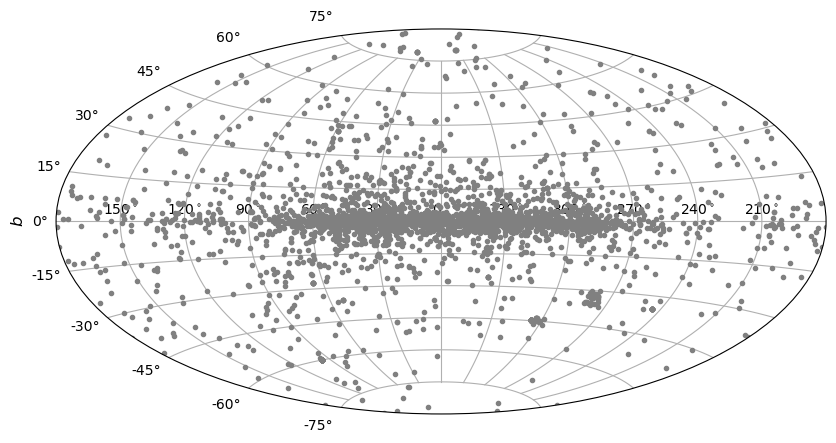

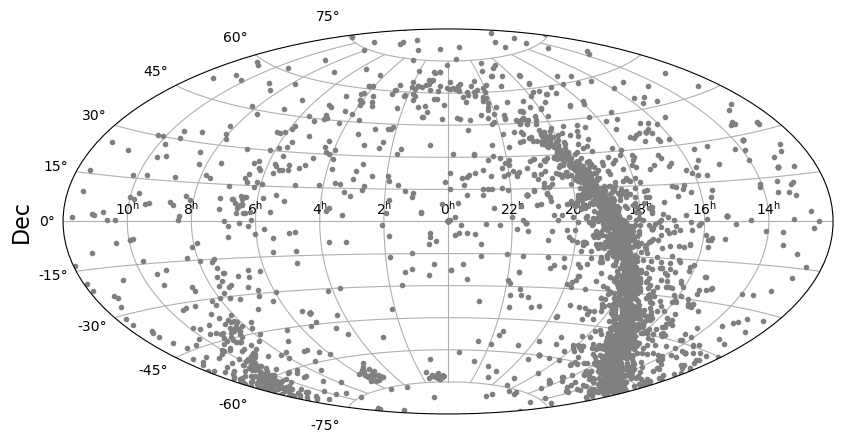

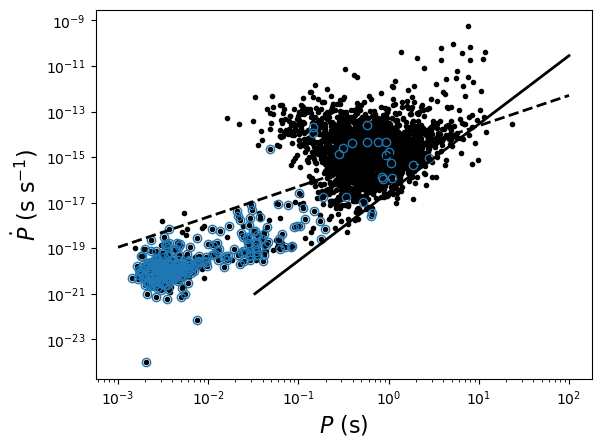

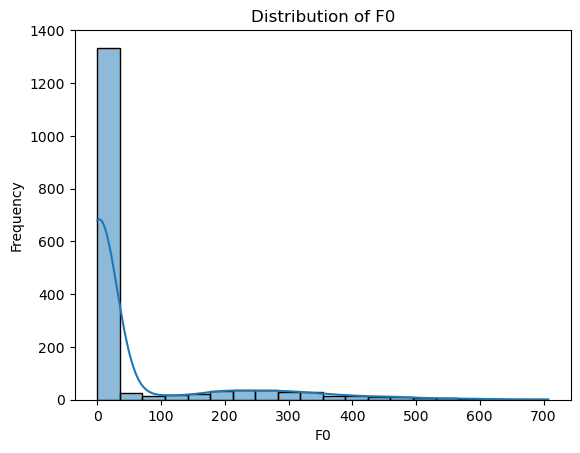

In [1]:
import astropy  # Import the core package for Astronomy
from astropy.table import Table, Column, MaskedColumn  # Import table classes for handling data
from astropy.coordinates import SkyCoord  # Import coordinate handling class
import numpy as np  # Import numpy for numerical operations
import matplotlib.pyplot as plt  # Import matplotlib for plotting
import seaborn as sns  # Import seaborn for advanced plotting
import urllib.request  # Import urllib for handling URL requests
import tarfile  # Import tarfile for extracting tar.gz files
from astropy import units as u  # Import units for handling astronomical units

# Download and extract the tar.gz file
pulsargzfile = urllib.request.urlopen('http://www.atnf.csiro.au/people/pulsar/psrcat/downloads/psrcat_pkg.tar.gz')  # Download the file
outputgzfile = open('psrcat_pkg.tar.gz', 'wb')  # Open a file to write the downloaded data
outputgzfile.write(pulsargzfile.read())  # Write the downloaded data to the file
outputgzfile.close()  # Close the file
pulsargzfile.close()  # Close the URL request

pulsargz = tarfile.open('psrcat_pkg.tar.gz', 'r')  # Open the downloaded tar.gz file
pulsargz.extractall()  # Extract all contents of the tar.gz file
pulsargz.close()  # Close the tar.gz file

# Function to determine data types
def getType(value):
    tests = [
        (float, float),  # Test if the value can be converted to a float
        (int, int),  # Test if the value can be converted to an int
        (str, lambda value: value.strip())  # Treat value as a string and strip whitespace
    ]
    for typ, test in tests:
        try:
            test(value)
            return typ  # Return the type if the conversion is successful
        except ValueError:
            continue
    # No match found, return string type
    return str

# Read and process the database file
psrcatdb = 'psrcat_tar/psrcat.db'  # Path to the database file
breakstring = '@-----------------------------------------------------------------'  # Delimiter for new entries
commentstring = '#'  # Comment identifier
versionstring = '#CATALOGUE'  # Version identifier

datafile = open(psrcatdb)  # Open the database file
psrtable = Table(masked=True)  # Create a masked table to handle missing data
ind = 0  # Index for the rows
masking = []  # List to keep track of masked values

for line in datafile:
    dataline = line.split()  # Split the line into components
    if dataline[0] == breakstring or dataline[0] == commentstring or dataline[0] == versionstring:
        if dataline[0] == breakstring:
            psrtable.add_row(None)  # Add a new row for each entry
            ind += 1  # Increment the row index
            psrtable.mask[ind] = masking  # Apply the mask to the new row
        continue

    if dataline[0] not in psrtable.colnames:
        masking.append(True)  # Add a mask for the new column
        thisdatatype = getType(dataline[1])  # Determine the data type of the column
        if thisdatatype == float:
            thisdtstr = 'f4'  # 4-byte floating point
        elif thisdatatype == int:
            thisdtstr = 'i2'  # 2-byte integer
        else:
            thisdtstr = 'S100'  # String of maximum length 100
        newcolumn = MaskedColumn(name=dataline[0], dtype=thisdtstr, mask=True, length=ind + 1)  # Create a new column with the appropriate type and mask
        psrtable.add_column(newcolumn)  # Add the new column to the table

    psrtable[dataline[0]][ind] = dataline[1]  # Assign the data value to the appropriate cell
    psrtable[dataline[0]].mask[ind] = False  # Unmask the cell

datafile.close()  # Close the database file

# Convert frequencies and derivatives into periods and derivatives
for obj in range(len(psrtable)):
    if not psrtable['F0'].mask[obj]:  # Check if F0 is not masked
        if psrtable['P0'].mask[obj]:  # Check if P0 is masked
            psrtable['P0'].mask[obj] = False  # Unmask P0
            psrtable['P0'][obj] = 1.0 / psrtable['F0'][obj]  # Calculate the period from the frequency
        if not psrtable['F1'].mask[obj]:  # Check if F1 is not masked
            if psrtable['P1'].mask[obj]:  # Check if P1 is masked
                psrtable['P1'].mask[obj] = False  # Unmask P1
                psrtable['P1'][obj] = (-1.0 * psrtable['F1'][obj]) / (psrtable['F0'][obj] ** 2)  # Calculate the period derivative

# Ensure RAJ and DECJ columns are strings and correctly formatted
psrtable['RAJ'] = psrtable['RAJ'].astype(str)  # Convert RAJ column to string type
psrtable['DECJ'] = psrtable['DECJ'].astype(str)  # Convert DECJ column to string type

# Convert coordinates from string to SkyCoord
psrtable['coord'] = SkyCoord(psrtable['RAJ'], psrtable['DECJ'], unit=(u.hourangle, u.deg))  # Convert RAJ and DECJ to SkyCoord

# Plotting
# 1. Aitoff projection for Galactic coordinates
fig = plt.figure(figsize=(10, 5))  # Create a figure
ax = plt.subplot(111, projection='aitoff')  # Create an Aitoff projection subplot
ax.grid(True)  # Enable the grid
ax.plot(-1 * psrtable['coord'].galactic.l.radian, psrtable['coord'].galactic.b.radian, '.', color='0.5')  # Plot the Galactic coordinates
ax.plot(2 * np.pi - psrtable['coord'].galactic.l.radian, psrtable['coord'].galactic.b.radian, '.', color='0.5')  # Mirror the coordinates for the Aitoff projection
ax.set_xticklabels([
    r'$150^\circ$', r'$120^\circ$', r'$90^\circ$', r'$60^\circ$',
    r'$30^\circ$', r'$0^\circ$', r'$330^\circ$', r'$300^\circ$',
    r'$270^\circ$', r'$240^\circ$', r'$210^\circ$'
])  # Set the x-axis labels
plt.ylabel(r'$b$', fontsize=12)  # Set the y-axis label
plt.show()  # Show the plot

# 2. Aitoff projection for Equatorial coordinates
fig = plt.figure(figsize=(10, 5))  # Create a figure
ax = plt.subplot(111, projection='aitoff')  # Create an Aitoff projection subplot
ax.grid(True)  # Enable the grid
ax.plot(-1 * psrtable['coord'].ra.radian, psrtable['coord'].dec.radian, '.', color='0.5')  # Plot the Equatorial coordinates
ax.plot(2 * np.pi - psrtable['coord'].ra.radian, psrtable['coord'].dec.radian, '.', color='0.5')  # Mirror the coordinates for the Aitoff projection
ax.set_xticklabels([
    r'$10^{\rm h}$', r'$8^{\rm h}$', r'$6^{\rm h}$', r'$4^{\rm h}$',
    r'$2^{\rm h}$', r'$0^{\rm h}$', r'$22^{\rm h}$', r'$20^{\rm h}$',
    r'$18^{\rm h}$', r'$16^{\rm h}$', r'$14^{\rm h}$'
])  # Set the x-axis labels
plt.ylabel(r'Dec', fontsize=16)  # Set the y-axis label
plt.show()  # Show the plot

# 3. P-Pdot diagram
fig = plt.figure()  # Create a figure
ax = plt.gca()  # Get the current axes
ax.plot(psrtable['P0'], psrtable['P1'], '.', c='black')  # Plot P0 vs P1
ax.set_yscale('log')  # Set y-axis to log scale
ax.set_xscale('log')  # Set x-axis to log scale
ax.plot(psrtable['P0'][psrtable['BINARY'].mask == False],
        psrtable['P1'][psrtable['BINARY'].mask == False], 'o', mfc='None')  # Highlight binary pulsars
ax.plot([0.0328449, 100], [1.0E-21, 2.8223E-11], color='k', linestyle='-', linewidth=2)  # Plot a reference line
ax.plot([1.E-3, 1.E2], [1.1E-19, 5.1E-13], color='k', linestyle='--', linewidth=2)  # Plot another reference line
plt.xlabel(r'$P\ {\rm(s)}$', fontsize=16)  # Set the x-axis label
plt.ylabel(r'$\dot{P}\ {\rm(s\ s^{-1})}$', fontsize=16)  # Set the y-axis label
plt.show()  # Show the plot

# 4. Distribution plot using seaborn
sns.histplot(psrtable['F0'].compressed(), bins=20, kde=True)  # Create a histogram of F0 with KDE using seaborn
plt.xlabel('F0')  # Set the x-axis label
plt.ylabel('Frequency')  # Set the y-axis label
plt.title('Distribution of F0')  # Set the plot title
plt.show()  # Show the plot

### Explanation of the First Cell

The first cell of the code performs the following tasks:

1. **Import Libraries:**
   - Imports necessary libraries for handling astronomical data, manipulating arrays, and plotting.

2. **Download and Extract Data:**
   - Downloads the pulsar catalog data from the ATNF website and extracts the contents from a tar.gz file.

3. **Define Helper Function:**
   - Defines a function to determine the data type of values in the catalog.

4. **Read and Process Database File:**
   - Reads the pulsar catalog file and creates a masked table to handle missing values.
   - Processes each line of the file to populate the table, handling comments and version strings.

5. **Convert Frequencies and Derivatives:**
   - Converts frequency (`F0`) and its derivative (`F1`) to period (`P0`) and its derivative (`P1`) for the pulsars.

6. **Format Coordinates:**
   - Ensures the Right Ascension (`RAJ`) and Declination (`DECJ`) columns are strings and converts them to `SkyCoord` objects for easy handling and plotting of celestial coordinates.

7. **Plot Data:**
   - Creates various plots:
     - **Aitoff Projection for Galactic Coordinates:** Shows the distribution of pulsars in the Galactic coordinate system.
     - **Aitoff Projection for Equatorial Coordinates:** Shows the distribution of pulsars in the Equatorial coordinate system.
     - **P-Pdot Diagram:** Plots the period against the period derivative, a key diagnostic tool for studying pulsar evolution.
     - **Distribution Plot:** Visualizes the distribution of the spin frequency (`F0`) of pulsars using seaborn.

This cell sets up the dataset and provides initial visual insights into the data, which are essential steps for understanding the structure and distribution of pulsars before applying machine learning techniques.

Silhouette Score: 0.708267331123352


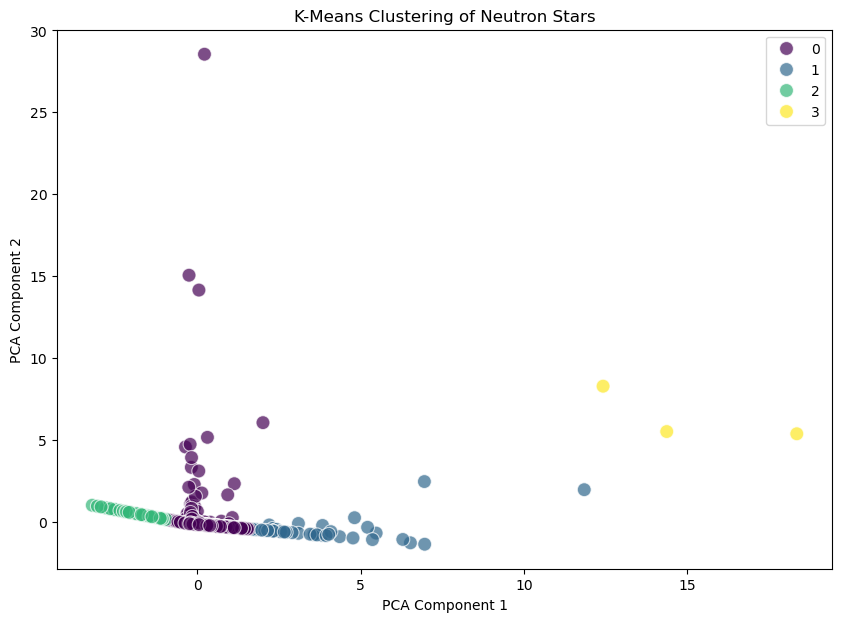

In [3]:
from sklearn.preprocessing import StandardScaler  # Import the StandardScaler for data standardization
from sklearn.decomposition import PCA  # Import PCA for dimensionality reduction
from sklearn.cluster import KMeans  # Import KMeans for clustering
from sklearn.metrics import silhouette_score  # Import silhouette_score for evaluating cluster quality
import matplotlib.pyplot as plt  # Import matplotlib for plotting
import seaborn as sns  # Import seaborn for enhanced visualization

# Extract relevant features and drop rows with missing values
features = ['P0', 'P1', 'F0', 'F1']  # Define the relevant features to be used
data = psrtable[features].to_pandas()  # Convert the relevant columns of the table to a pandas DataFrame
data = data.dropna()  # Drop rows with missing values

# Standardize the data
scaler = StandardScaler()  # Initialize the StandardScaler
data_scaled = scaler.fit_transform(data)  # Fit the scaler on the data and transform it

# Dimensionality reduction for visualization
pca = PCA(n_components=2)  # Initialize PCA to reduce data to 2 components for visualization
data_pca = pca.fit_transform(data_scaled)  # Fit PCA on the scaled data and transform it

# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Initialize KMeans with 4 clusters and a fixed random state
clusters = kmeans.fit_predict(data_scaled)  # Fit KMeans on the scaled data and predict cluster assignments

# Evaluation of Clusters
silhouette_avg = silhouette_score(data_scaled, clusters)  # Calculate the silhouette score to evaluate clustering
print(f'Silhouette Score: {silhouette_avg}')  # Print the silhouette score

# Visualization of Clusters
plt.figure(figsize=(10, 7))  # Create a figure for the plot with specified size
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=clusters, palette='viridis', s=100, alpha=0.7)  # Create a scatter plot with PCA components, colored by clusters
plt.title('K-Means Clustering of Neutron Stars')  # Set the plot title
plt.xlabel('PCA Component 1')  # Set the x-axis label
plt.ylabel('PCA Component 2')  # Set the y-axis label
plt.show()  # Show the plot

### Explanation of the Second Cell

The second cell of the code focuses on clustering the neutron stars using K-Means clustering. Here is a step-by-step breakdown:

1. **Import Libraries:**
   - Imports necessary libraries for preprocessing, dimensionality reduction, clustering, and visualization.

2. **Extract Relevant Features:**
   - Selects relevant features (`P0`, `P1`, `F0`, `F1`) from the `psrtable` and converts it to a pandas DataFrame.
   - Drops rows with missing values to ensure the data is complete for analysis.

3. **Standardize the Data:**
   - Uses `StandardScaler` to standardize the data, ensuring each feature contributes equally to the clustering process.

4. **Dimensionality Reduction:**
   - Applies Principal Component Analysis (PCA) to reduce the dimensionality of the data to 2 components for visualization purposes.

5. **K-Means Clustering:**
   - Applies K-Means clustering to the standardized data, specifying 4 clusters and a random state for reproducibility.

6. **Evaluate Clusters:**
   - Computes the silhouette score to evaluate the quality of the clusters. A higher silhouette score indicates better-defined clusters.

7. **Visualize Clusters:**
   - Creates a scatter plot of the PCA-reduced data, coloring points by their cluster assignments. This helps visualize the separation and cohesion of the clusters.

This cell preprocesses the data, applies K-Means clustering, evaluates the clustering performance, and visualizes the clusters, providing insights into the structure and grouping of neutron stars based on the selected features.

Hierarchical Clustering Silhouette Score: 0.6735705733299255


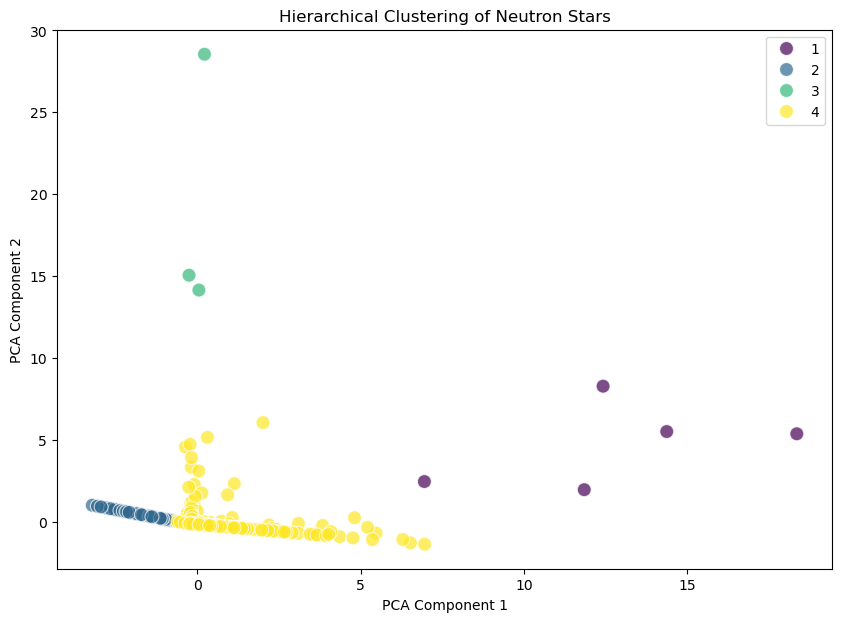

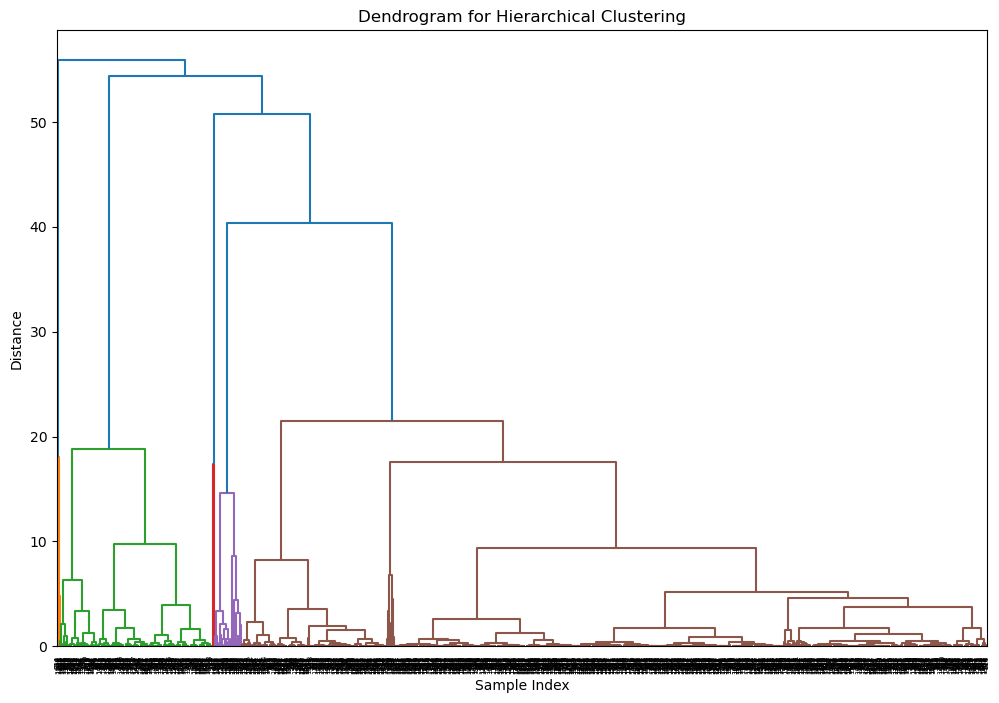

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster  # Import functions for hierarchical clustering and visualization

# Hierarchical Clustering
Z = linkage(data_scaled, method='ward')  # Perform hierarchical clustering using Ward's method
hier_clusters = fcluster(Z, t=4, criterion='maxclust')  # Form flat clusters from the hierarchical tree with 4 clusters

# Evaluation of Hierarchical Clusters
silhouette_avg_hier = silhouette_score(data_scaled, hier_clusters)  # Calculate the silhouette score for hierarchical clusters
print(f'Hierarchical Clustering Silhouette Score: {silhouette_avg_hier}')  # Print the silhouette score

# Visualization of Hierarchical Clusters
plt.figure(figsize=(10, 7))  # Set the size of the figure
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=hier_clusters, palette='viridis', s=100, alpha=0.7)  # Create a scatter plot of PCA components with hierarchical cluster labels
plt.title('Hierarchical Clustering of Neutron Stars')  # Set the title of the plot
plt.xlabel('PCA Component 1')  # Label the x-axis
plt.ylabel('PCA Component 2')  # Label the y-axis
plt.show()  # Display the plot

# Dendrogram
plt.figure(figsize=(12, 8))  # Set the size of the figure
dendrogram(Z)  # Plot the dendrogram based on the linkage matrix
plt.title('Dendrogram for Hierarchical Clustering')  # Set the title of the dendrogram
plt.xlabel('Sample Index')  # Label the x-axis
plt.ylabel('Distance')  # Label the y-axis
plt.show()  # Display the dendrogram

### Explanation of the Third Cell

The third cell focuses on performing hierarchical clustering on the neutron star data. Here's a breakdown of its functionality:

1. **Import Libraries:**
   - Imports necessary libraries for hierarchical clustering and visualization.

2. **Hierarchical Clustering:**
   - Performs hierarchical clustering on the standardized data using the Ward's method, which minimizes the variance within clusters.
   - Generates a linkage matrix `Z` that encodes the hierarchical clustering structure.
   - Assigns cluster labels to the data by cutting the hierarchical tree at a height that forms 4 clusters.

3. **Evaluate Hierarchical Clusters:**
   - Computes the silhouette score to evaluate the quality of the hierarchical clusters. A higher silhouette score indicates better-defined clusters.

4. **Visualize Hierarchical Clusters:**
   - Creates a scatter plot of the PCA-reduced data, coloring points by their hierarchical cluster assignments. This helps visualize the separation and cohesion of the clusters.

5. **Dendrogram:**
   - Plots a dendrogram using the linkage matrix `Z`, which shows the hierarchical relationships between the data points. The dendrogram illustrates how clusters are merged at each step of the hierarchical clustering process.

This cell implements hierarchical clustering, evaluates the clustering performance, and visualizes the clusters and the hierarchical structure, providing additional insights into the grouping of neutron stars.

DBSCAN Silhouette Score: 0.7339337468147278


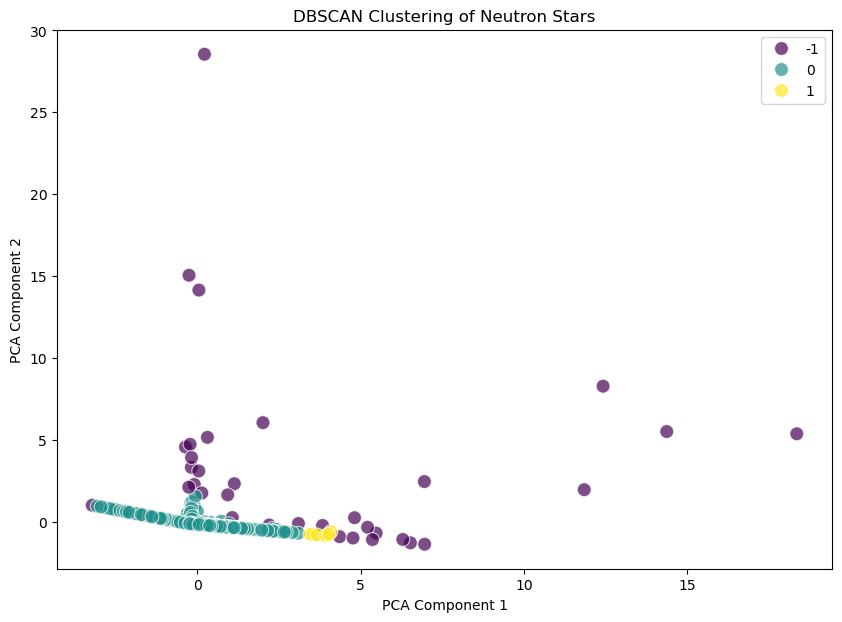

In [7]:
from sklearn.cluster import DBSCAN  # Import the DBSCAN clustering algorithm from scikit-learn

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Initialize the DBSCAN algorithm with epsilon (eps) set to 0.5 and minimum samples (min_samples) set to 5
dbscan_clusters = dbscan.fit_predict(data_scaled)  # Fit the DBSCAN model to the scaled data and predict the cluster labels

# Evaluation of DBSCAN Clusters
silhouette_avg_dbscan = silhouette_score(data_scaled, dbscan_clusters)  # Calculate the silhouette score to evaluate the quality of the DBSCAN clusters
print(f'DBSCAN Silhouette Score: {silhouette_avg_dbscan}')  # Print the silhouette score for DBSCAN clustering

# Visualization of DBSCAN Clusters
plt.figure(figsize=(10, 7))  # Set the size of the figure for the plot
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=dbscan_clusters, palette='viridis', s=100, alpha=0.7)  # Create a scatter plot of PCA components with DBSCAN cluster labels
plt.title('DBSCAN Clustering of Neutron Stars')  # Set the title of the scatter plot
plt.xlabel('PCA Component 1')  # Label the x-axis of the plot
plt.ylabel('PCA Component 2')  # Label the y-axis of the plot
plt.show()  # Display the scatter plot


### Explanation

1. **Importing DBSCAN**: The `DBSCAN` algorithm is imported from scikit-learn, which is used for density-based clustering.

2. **DBSCAN Clustering**:
   - `dbscan = DBSCAN(eps=0.5, min_samples=5)`: The `DBSCAN` algorithm is initialized with `eps` (maximum distance between samples to be considered neighbors) set to 0.5 and `min_samples` (minimum number of samples in a neighborhood for a point to be considered as a core point) set to 5.
   - `dbscan_clusters = dbscan.fit_predict(data_scaled)`: The `fit_predict` method applies the DBSCAN algorithm to the scaled data, assigning each data point to a cluster and returning an array of cluster labels.

3. **Evaluation of DBSCAN Clusters**:
   - `silhouette_avg_dbscan = silhouette_score(data_scaled, dbscan_clusters)`: The silhouette score, which measures how similar each point is to its own cluster compared to other clusters, is computed to evaluate the quality of clustering.
   - `print(f'DBSCAN Silhouette Score: {silhouette_avg_dbscan}')`: The silhouette score is printed to provide an assessment of the clustering performance.

4. **Visualization of DBSCAN Clusters**:
   - `plt.figure(figsize=(10, 7))`: The size of the figure for the plot is set to 10 by 7 inches.
   - `sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=dbscan_clusters, palette='viridis', s=100, alpha=0.7)`: A scatter plot of the PCA-transformed data is created with points colored according to their DBSCAN cluster labels. The `hue` parameter is set to `dbscan_clusters` to use the cluster labels for coloring, `palette='viridis'` specifies the color map, `s=100` sets the size of the points, and `alpha=0.7` sets the transparency.
   - `plt.title('DBSCAN Clustering of Neutron Stars')`: The title of the scatter plot is set.
   - `plt.xlabel('PCA Component 1')` and `plt.ylabel('PCA Component 2')`: Labels for the x and y axes are set.
   - `plt.show()`: Displays the scatter plot, showing the clustering result.

Cluster Distribution: {-1: 34, 0: 1593, 1: 8}
               P0            P1         F0            F1
cluster                                                 
-1       3.901096  5.864260e-12  28.753023 -3.857347e-11
 0       0.644499  1.391066e-14  53.076191 -2.494105e-13
 1       6.654528  2.360560e-13   0.150528 -5.166234e-15


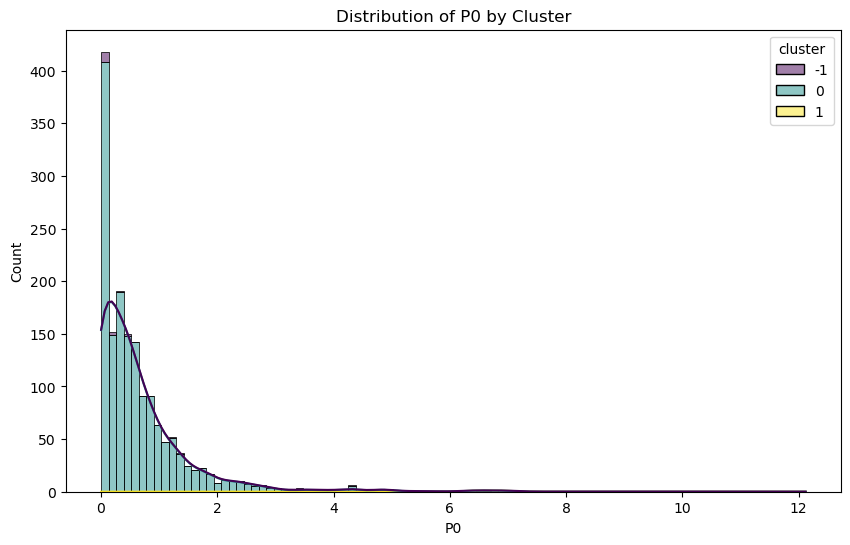

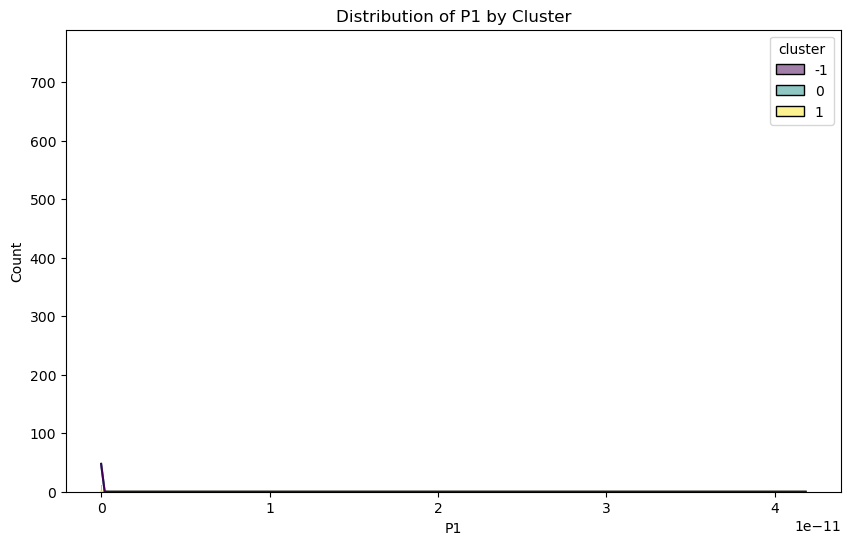

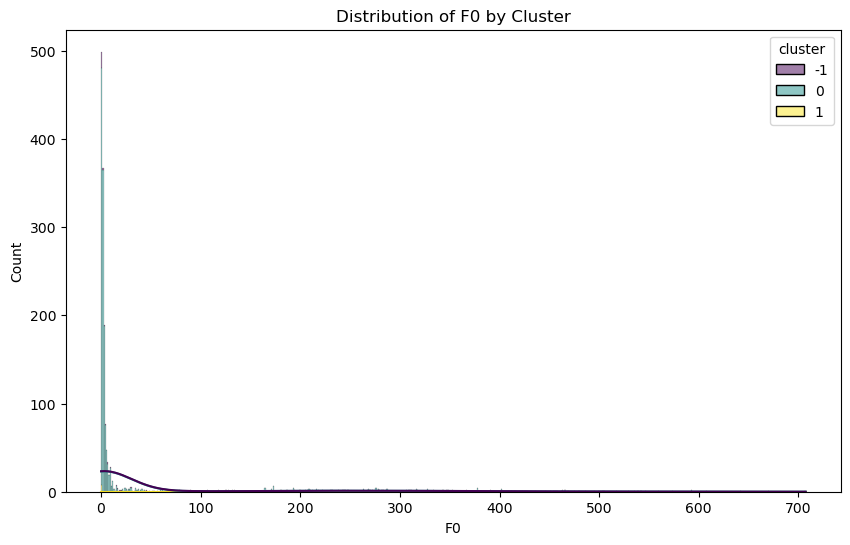

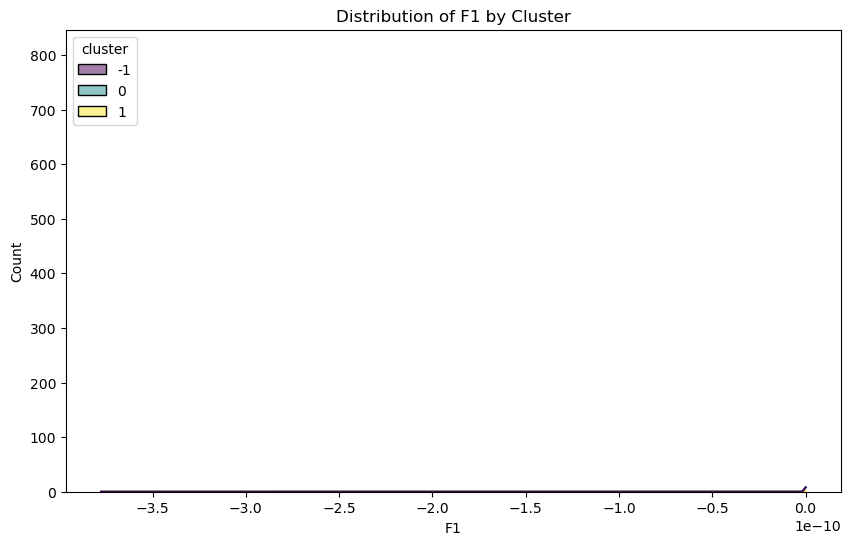

In [9]:
# Analyze cluster distribution
unique, counts = np.unique(dbscan_clusters, return_counts=True)  # Get unique cluster labels and their counts from the DBSCAN results
cluster_distribution = dict(zip(unique, counts))  # Create a dictionary of cluster labels and their counts
print(f'Cluster Distribution: {cluster_distribution}')  # Print the distribution of clusters

# Add clusters to the dataframe
data['cluster'] = dbscan_clusters  # Add the cluster labels to the original dataframe as a new column named 'cluster'

# Analyze properties of each cluster
cluster_summary = data.groupby('cluster').mean()  # Calculate the mean of each feature for each cluster
print(cluster_summary)  # Print the summary of cluster properties

# Visualize distributions of features within each cluster
for feature in features:  # Loop through each feature
    plt.figure(figsize=(10, 6))  # Set the size of the figure for the plot
    sns.histplot(data=data, x=feature, hue='cluster', multiple='stack', palette='viridis', kde=True)  # Create a histogram of the feature values, colored by cluster, with KDE overlay
    plt.title(f'Distribution of {feature} by Cluster')  # Set the title of the plot
    plt.show()  # Display the histogram


### Explanation

1. **Analyze Cluster Distribution**:
   - `unique, counts = np.unique(dbscan_clusters, return_counts=True)`: This line extracts unique cluster labels and their frequencies from the DBSCAN clustering results.
   - `cluster_distribution = dict(zip(unique, counts))`: A dictionary is created mapping each unique cluster label to its count.
   - `print(f'Cluster Distribution: {cluster_distribution}')`: The distribution of clusters is printed, showing how many data points are assigned to each cluster.

2. **Add Clusters to the DataFrame**:
   - `data['cluster'] = dbscan_clusters`: The cluster labels are added to the original DataFrame as a new column named `'cluster'`, allowing for easy access to cluster assignments alongside the feature data.

3. **Analyze Properties of Each Cluster**:
   - `cluster_summary = data.groupby('cluster').mean()`: This line groups the data by cluster and calculates the mean value of each feature within each cluster.
   - `print(cluster_summary)`: The mean values for each feature by cluster are printed, summarizing the properties of each cluster.

4. **Visualize Distributions of Features within Each Cluster**:
   - `for feature in features`: This loop iterates over each feature specified in the `features` list.
   - `plt.figure(figsize=(10, 6))`: Sets the size of the figure for the histogram plots.
   - `sns.histplot(data=data, x=feature, hue='cluster', multiple='stack', palette='viridis', kde=True)`: Creates a stacked histogram for each feature, with bars colored according to cluster labels. `kde=True` adds a kernel density estimate overlay to the histogram.
   - `plt.title(f'Distribution of {feature} by Cluster')`: Sets the title of the histogram plot for the current feature.
   - `plt.show()`: Displays the histogram for the current feature, providing a visual representation of feature distributions across clusters.

In [11]:
import tensorflow as tf  # Import TensorFlow library
from tensorflow.keras.models import Model  # Import Model class from Keras
from tensorflow.keras.layers import Input, Dense  # Import Input and Dense layers from Keras

# Define the autoencoder model
input_dim = data_scaled.shape[1]  # Set the input dimension based on the number of features
encoding_dim = 2  # Define the dimension of the encoded representation

input_layer = Input(shape=(input_dim,))  # Define the input layer with the shape of the input data
encoder = Dense(encoding_dim, activation='relu')(input_layer)  # Define the encoder layer with ReLU activation
decoder = Dense(input_dim, activation='sigmoid')(encoder)  # Define the decoder layer with sigmoid activation

autoencoder = Model(inputs=input_layer, outputs=decoder)  # Create the autoencoder model
encoder_model = Model(inputs=input_layer, outputs=encoder)  # Create a separate encoder model

autoencoder.compile(optimizer='adam', loss='mse')  # Compile the autoencoder model with Adam optimizer and MSE loss

# Train the autoencoder
autoencoder.fit(data_scaled, data_scaled, epochs=50, batch_size=32, shuffle=True, validation_split=0.2, verbose=0)  # Train the autoencoder model

# Encode the data
encoded_data = encoder_model.predict(data_scaled)  # Use the encoder model to encode the data

# K-Means Clustering on encoded data
kmeans_encoded = KMeans(n_clusters=3, random_state=42, n_init='auto')  # Define K-Means clustering with 3 clusters
clusters_encoded = kmeans_encoded.fit_predict(encoded_data)  # Perform K-Means clustering on the encoded data

# Evaluation of Clusters on encoded data
silhouette_avg_encoded = silhouette_score(encoded_data, clusters_encoded)  # Calculate the silhouette score for the clustering
print(f'Autoencoder + K-Means Silhouette Score: {silhouette_avg_encoded}')  # Print the silhouette score

# Visualization of Clusters on encoded data
plt.figure(figsize=(10, 7))  # Set the size of the figure
sns.scatterplot(x=encoded_data[:, 0], y=encoded_data[:, 1], hue=clusters_encoded, palette='viridis', s=100, alpha=0.7)  # Scatter plot of the encoded data colored by cluster
plt.title('Autoencoder + K-Means Clustering of Neutron Stars')  # Set the title of the plot
plt.xlabel('Encoded Dimension 1')  # Set the x-axis label
plt.ylabel('Encoded Dimension 2')  # Set the y-axis label
plt.show()  # Display the scatter plot

ModuleNotFoundError: No module named 'tensorflow'


### Explanation

1. **Import Libraries**:
   - `import tensorflow as tf`: Imports TensorFlow library for building and training neural networks.
   - `from tensorflow.keras.models import Model`: Imports the Model class for creating neural network models.
   - `from tensorflow.keras.layers import Input, Dense`: Imports the Input and Dense layers for building the autoencoder.

2. **Define the Autoencoder Model**:
   - `input_dim = data_scaled.shape[1]`: Gets the number of features (input dimensions) from the scaled data.
   - `encoding_dim = 2`: Sets the number of dimensions for the encoded representation.
   - `input_layer = Input(shape=(input_dim,))`: Defines the input layer with the shape of the input data.
   - `encoder = Dense(encoding_dim, activation='relu')(input_layer)`: Defines the encoder layer with ReLU activation function, reducing dimensions to `encoding_dim`.
   - `decoder = Dense(input_dim, activation='sigmoid')(encoder)`: Defines the decoder layer with sigmoid activation function, reconstructing the input data.

3. **Compile and Train the Autoencoder**:
   - `autoencoder = Model(inputs=input_layer, outputs=decoder)`: Creates the autoencoder model with the specified input and output layers.
   - `encoder_model = Model(inputs=input_layer, outputs=encoder)`: Creates a separate encoder model to extract the encoded representation.
   - `autoencoder.compile(optimizer='adam', loss='mse')`: Compiles the autoencoder model using the Adam optimizer and mean squared error loss.
   - `autoencoder.fit(...)`: Trains the autoencoder model using the scaled data for 50 epochs with a batch size of 32, including a validation split.

4. **Encode the Data**:
   - `encoded_data = encoder_model.predict(data_scaled)`: Encodes the scaled data using the trained encoder model.

5. **K-Means Clustering on Encoded Data**:
   - `kmeans_encoded = KMeans(n_clusters=3, random_state=42, n_init='auto')`: Initializes K-Means clustering with 3 clusters.
   - `clusters_encoded = kmeans_encoded.fit_predict(encoded_data)`: Performs clustering on the encoded data and assigns cluster labels.

6. **Evaluate Clustering Results**:
   - `silhouette_avg_encoded = silhouette_score(encoded_data, clusters_encoded)`: Calculates the silhouette score for the clustering to evaluate its quality.
   - `print(f'Autoencoder + K-Means Silhouette Score: {silhouette_avg_encoded}')`: Prints the silhouette score for the clustering.

7. **Visualize Clusters**:
   - `plt.figure(figsize=(10, 7))`: Sets the figure size for the scatter plot.
   - `sns.scatterplot(...)`: Creates a scatter plot of the encoded data with colors indicating different clusters.
   - `plt.title('Autoencoder + K-Means Clustering of Neutron Stars')`: Sets the plot title.
   - `plt.xlabel('Encoded Dimension 1')` and `plt.ylabel('Encoded Dimension 2')`: Label the axes of the scatter plot.
   - `plt.show()`: Displays the scatter plot showing the clustering results on the encoded data.

In [ ]:
from sklearn.cluster import DBSCAN  # Import the DBSCAN clustering algorithm from scikit-learn

# Apply DBSCAN on the encoded data
dbscan_encoded = DBSCAN(eps=0.5, min_samples=5)  # Initialize DBSCAN with epsilon (eps) and minimum samples parameters
clusters_encoded_dbscan = dbscan_encoded.fit_predict(encoded_data)  # Fit DBSCAN on encoded data and predict clusters

# Evaluation of DBSCAN Clusters on encoded data
silhouette_avg_encoded_dbscan = silhouette_score(encoded_data, clusters_encoded_dbscan)  # Compute silhouette score for DBSCAN clusters
print(f'Autoencoder + DBSCAN Silhouette Score: {silhouette_avg_encoded_dbscan}')  # Print the silhouette score

# Visualizing the DBSCAN clusters on encoded data
plt.figure(figsize=(10, 7))  # Set the size of the figure
sns.scatterplot(x=encoded_data[:, 0], y=encoded_data[:, 1], hue=clusters_encoded_dbscan, palette='viridis', s=100, alpha=0.7)  # Scatter plot of encoded data with DBSCAN clusters
plt.title('Autoencoder + DBSCAN Clustering of Neutron Stars')  # Set the title of the plot
plt.xlabel('Encoded Dimension 1')  # Set the x-axis label
plt.ylabel('Encoded Dimension 2')  # Set the y-axis label
plt.show()  # Display the scatter plot

# Analyze cluster distribution
unique_encoded_dbscan, counts_encoded_dbscan = np.unique(clusters_encoded_dbscan, return_counts=True)  # Count occurrences of each cluster label
cluster_distribution_encoded_dbscan = dict(zip(unique_encoded_dbscan, counts_encoded_dbscan))  # Create a dictionary of cluster distribution
print(f'Cluster Distribution (Autoencoder + DBSCAN): {cluster_distribution_encoded_dbscan}')  # Print the cluster distribution

# Add clusters to the dataframe
data['cluster_encoded_dbscan'] = clusters_encoded_dbscan  # Add the DBSCAN cluster labels to the dataframe

# Analyze properties of each cluster
cluster_summary_encoded_dbscan = data.groupby('cluster_encoded_dbscan').mean()  # Compute mean values of features for each cluster
print(cluster_summary_encoded_dbscan)  # Print the cluster summary

# Following code is commented out for faster execution, un-comment to visualize distributions of features within each cluster
"""for feature in features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x=feature, hue='cluster_encoded_dbscan', multiple='stack', palette='viridis', kde=True)
    plt.title(f'Distribution of {feature} by Autoencoder + DBSCAN Cluster')
    plt.show()"""  # (Commented out) Code to visualize feature distributions within each DBSCAN cluster


### Explanation

1. **Apply DBSCAN on Encoded Data**:
   - `dbscan_encoded = DBSCAN(eps=0.5, min_samples=5)`: Initializes the DBSCAN algorithm with `eps` (maximum distance between samples) and `min_samples` (minimum number of samples for a cluster).
   - `clusters_encoded_dbscan = dbscan_encoded.fit_predict(encoded_data)`: Applies DBSCAN clustering to the encoded data and assigns cluster labels.

2. **Evaluate Clustering Results**:
   - `silhouette_avg_encoded_dbscan = silhouette_score(encoded_data, clusters_encoded_dbscan)`: Calculates the silhouette score for DBSCAN clusters, which measures the quality of clustering.
   - `print(f'Autoencoder + DBSCAN Silhouette Score: {silhouette_avg_encoded_dbscan}')`: Prints the silhouette score to evaluate clustering performance.

3. **Visualize DBSCAN Clusters**:
   - `plt.figure(figsize=(10, 7))`: Sets the size of the figure for visualization.
   - `sns.scatterplot(...)`: Creates a scatter plot of the encoded data, coloring points by their DBSCAN cluster labels.
   - `plt.title('Autoencoder + DBSCAN Clustering of Neutron Stars')`: Adds a title to the plot.
   - `plt.xlabel('Encoded Dimension 1')` and `plt.ylabel('Encoded Dimension 2')`: Labels the axes of the scatter plot.
   - `plt.show()`: Displays the scatter plot showing DBSCAN clustering results.

4. **Analyze Cluster Distribution**:
   - `unique_encoded_dbscan, counts_encoded_dbscan = np.unique(clusters_encoded_dbscan, return_counts=True)`: Counts the number of occurrences of each cluster label.
   - `cluster_distribution_encoded_dbscan = dict(zip(unique_encoded_dbscan, counts_encoded_dbscan))`: Creates a dictionary to represent the distribution of clusters.
   - `print(f'Cluster Distribution (Autoencoder + DBSCAN): {cluster_distribution_encoded_dbscan}')`: Prints the distribution of clusters.

5. **Add Clusters to DataFrame**:
   - `data['cluster_encoded_dbscan'] = clusters_encoded_dbscan`: Adds the cluster labels from DBSCAN to the original dataframe for further analysis.

6. **Analyze Cluster Properties**:
   - `cluster_summary_encoded_dbscan = data.groupby('cluster_encoded_dbscan').mean()`: Computes the average values of features for each DBSCAN cluster.
   - `print(cluster_summary_encoded_dbscan)`: Prints the summary of cluster properties.

7. **(Commented Out) Visualize Feature Distributions**:
   - The commented-out code would plot histograms of feature distributions for each DBSCAN cluster, which can be uncommented if needed for detailed analysis.